## Time Series Analysis Challenge 5.2.6

* For this challenge I chose the Population Time Series Data provided by the US Census Bureau. The dataset was obtained on Kaggle at the following address: https://www.kaggle.com/datasets/census/population-time-series-data?select=POP.csv
<br>

* I will be examining the change in population over time and addressing the following objectives
<br>

> * Plot the time series, along with any logical or necessary differences to get a stationary dataset.
<br>
> * Generate and interpret a PACF for the time series and discuss any differences in correlations.
<br>
> * Generate five ARIMA specifications and evaluate their efficacy at modeling your data.
<br>
> * Finally, choose one specification and make a case for it as a logical model for your dataset. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import datetime as dt
%matplotlib inline

df = pd.read_csv(r"F:\DataSets\population_time_series\POP.csv")

In [2]:
df.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.0,1952-01-01,2019-12-06
1,2019-12-06,156527.0,1952-02-01,2019-12-06
2,2019-12-06,156731.0,1952-03-01,2019-12-06
3,2019-12-06,156943.0,1952-04-01,2019-12-06
4,2019-12-06,157140.0,1952-05-01,2019-12-06


In [3]:
# For the purpose of this exercise I will be dropping the "realtime" columns to focus on the monthly date and population count.

df = df.drop(['realtime_start', 'realtime_end'], axis=1).assign(
    date=pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce').dt.to_period('M')
).set_index('date')

In [4]:
df.isnull().sum()

value    0
dtype: int64

In [5]:
df.head()

,value
date,
1952-01,156309.0
1952-02,156527.0
1952-03,156731.0
1952-04,156943.0
1952-05,157140.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 816 entries, 1952-01 to 2019-12
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   816 non-null    float64
dtypes: float64(1)
memory usage: 12.8 KB


<Axes: xlabel='date'>

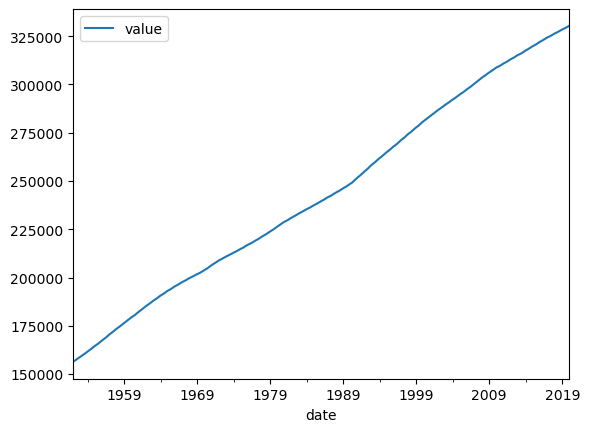

In [7]:
df.plot()

* There appears to be a strong trend in the data of population rising over time.

Text(0.5, 1.0, 'Population ACF')

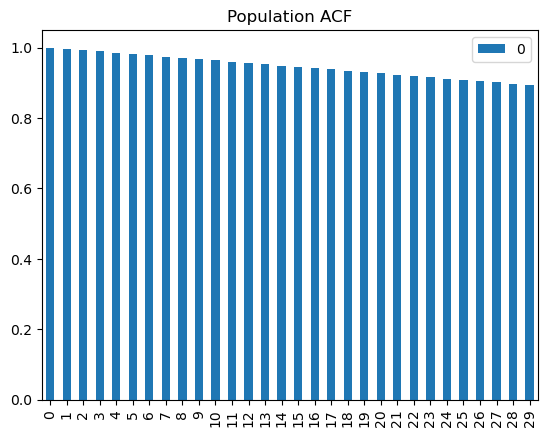

In [8]:
from statsmodels.tsa.stattools import acf
x_acf = pd.DataFrame(acf(df.value))
x_acf.plot(kind='bar')
plt.title('Population ACF')

* The ACF shows strong a correlation for all lag points. This indicates a strong seasonality or trend and that the data is non-stationary.

Text(0.5, 1.0, 'Population PACF')

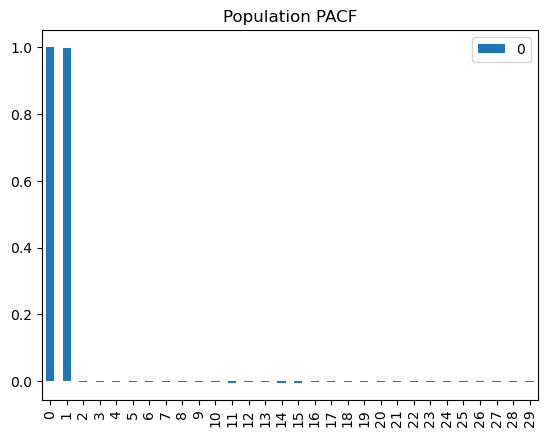

In [9]:
from statsmodels.tsa.stattools import pacf
x_acf = pd.DataFrame(pacf(df.value))
x_acf.plot(kind='bar')
plt.title('Population PACF')

* The PACF has a strong correlation at lag = 1 then drops off significantly. This indicates an AR process.

In [10]:
# Confirming the data is non-stationary

from statsmodels.tsa.stattools import adfuller

result = adfuller(df['value'])
print('ADF Statistic:%f'% result[0])
print('p-value:%f'% result[1])

ADF Statistic:-0.665317
p-value:0.855530


* The p-value > 0.05 I can accept the null that the series is non-stationary.

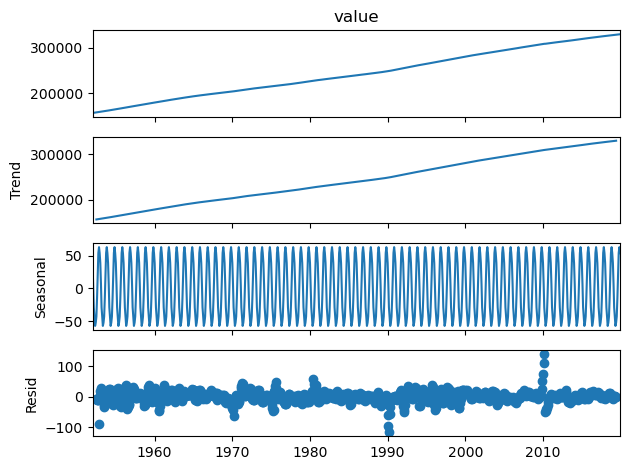

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

df.index = pd.to_datetime(df.index.to_timestamp())
decomposition = seasonal_decompose(df['value'], model='additive', period=12)
x = decomposition.plot()

* The plot indicates a strong positive trend. 
<br>
* The seasonal pattern has a realativly weak amplitude therefore not as regular or predictible.

Significance level : 0.05
ADF test static is 0.2822512276644459


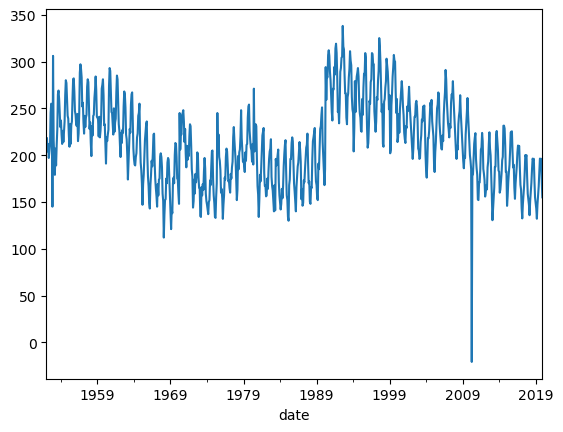

In [12]:
# Determining order of difference needed
# 1st

df['stationary'] = df['value'].diff()
df['stationary'].plot()

print('Significance level : 0.05')
adf = adfuller(df['stationary'].dropna())
print(f'ADF test static is {adf[1]}')

* ADF p-value > 0.05 still

Significance level : 0.05
ADF test static is 2.1100121875842832e-10


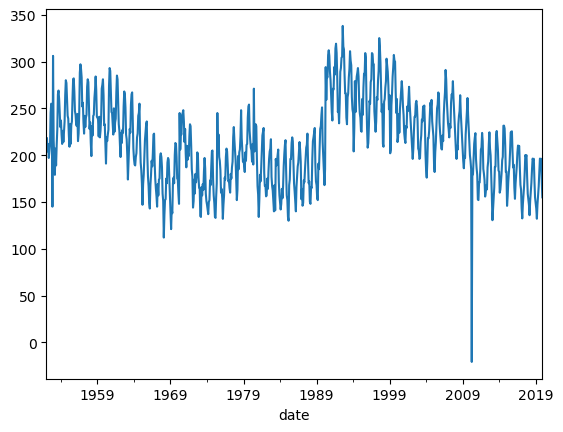

In [13]:
# 2nd

df['stationary_1'] = df['stationary'].diff()
df['stationary'].plot()

print('Significance level : 0.05')
adf = adfuller(df['stationary_1'].dropna())
print(f'ADF test static is {adf[1]}')

Text(0.5, 1.0, 'Population PACF 2nd Difference')

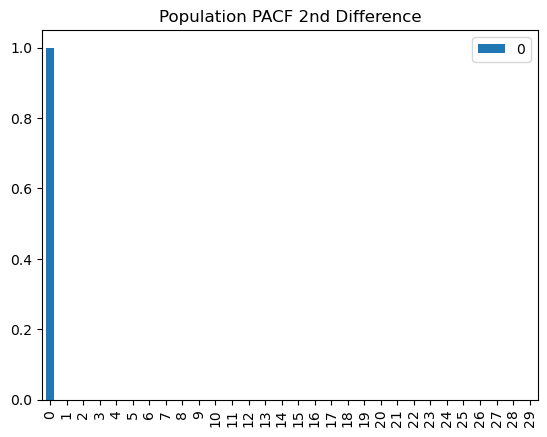

In [14]:
x_acf = pd.DataFrame(pacf(df.stationary_1))
x_acf.plot(kind='bar')
plt.title('Population PACF 2nd Difference')

* The data appears stationary visually and ADF p-value < 0.05
<br>
* Will iterate through several combinations of specifications for an ARIMA model and choose the best one's best on lowest AIC score

In [15]:
import itertools
import warnings
import statsmodels.api as sm

# Split the data into training and testing sets
train_size = int(len(df['value']) * 0.8)
train_data, test_data = df['value'][:train_size], df['value'][train_size:]

# Define the range of values for p, d, and q
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# Generate all possible combinations of p, d, and q
pdq = list(itertools.product(p, d, q))

# Fit ARIMA models for all combinations of p, d, and q
lowest_aic, best_params = float("inf"), None
warnings.filterwarnings("ignore")
for param in pdq:        
    try:
        # Fit an ARIMA model with the current parameter combination (p,d,q)
        model = sm.tsa.ARIMA(train_data, order=param)  
        result = model.fit()
        
        # Compute the AIC value for the current model
        aic = result.aic
        
        # Print the AIC and parameter values for the current model
        print(f"ARIMA parameters: P = {param[0]}, D = {param[1]}, Q = {param[2]}. AIC = {aic}")
        
        # Keep track of the lowest AIC value and the best parameter combination
        if aic < lowest_aic:
            lowest_aic = aic
            best_params = param
    except:
        continue
        
print(f"Best ARIMA parameters: P = {best_params[0]}, D = {best_params[1]}, Q = {best_params[2]}. AIC = {lowest_aic}.")

ARIMA parameters: P = 0, D = 0, Q = 0. AIC = 19228.751697576925
ARIMA parameters: P = 0, D = 0, Q = 1. AIC = 14763.014266856473
ARIMA parameters: P = 0, D = 0, Q = 2. AIC = 13965.514560440794
ARIMA parameters: P = 0, D = 1, Q = 0. AIC = 8886.588278462486
ARIMA parameters: P = 0, D = 1, Q = 1. AIC = 8287.683085222108
ARIMA parameters: P = 0, D = 1, Q = 2. AIC = 7847.434644911127
ARIMA parameters: P = 1, D = 0, Q = 0. AIC = 8916.254759933709
ARIMA parameters: P = 1, D = 0, Q = 1. AIC = 8134.034459654673
ARIMA parameters: P = 1, D = 0, Q = 2. AIC = 7504.139918549248
ARIMA parameters: P = 1, D = 1, Q = 0. AIC = 5995.420050989211
ARIMA parameters: P = 1, D = 1, Q = 1. AIC = 5985.681165658501
ARIMA parameters: P = 1, D = 1, Q = 2. AIC = 5978.3378723918195
ARIMA parameters: P = 2, D = 0, Q = 0. AIC = 5878.5845639430045
ARIMA parameters: P = 2, D = 0, Q = 1. AIC = 5876.429652555742
ARIMA parameters: P = 2, D = 0, Q = 2. AIC = 5859.284591455881
ARIMA parameters: P = 2, D = 1, Q = 0. AIC = 5984.

* Now with the parameters selected, the model will be run and the residuals plotted

In [16]:
# Run the model

from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv(r"F:\DataSets\population_time_series\POP.csv")

df = df[['value']]

# Define the ARIMA model
model = ARIMA(df['value'].diff().dropna(), order=(1, 0, 1))

# Fit the model to the data
model_fit = model.fit()

# Print the model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  815
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3670.140
Date:                Fri, 18 Aug 2023   AIC                           7348.280
Time:                        17:42:07   BIC                           7367.093
Sample:                             0   HQIC                          7355.501
                                - 815                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        213.4934      6.337     33.688      0.000     201.073     225.914
ar.L1          0.8759      0.022     39.382      0.000       0.832       0.919
ma.L1         -0.0353      0.028     -1.277      0.2

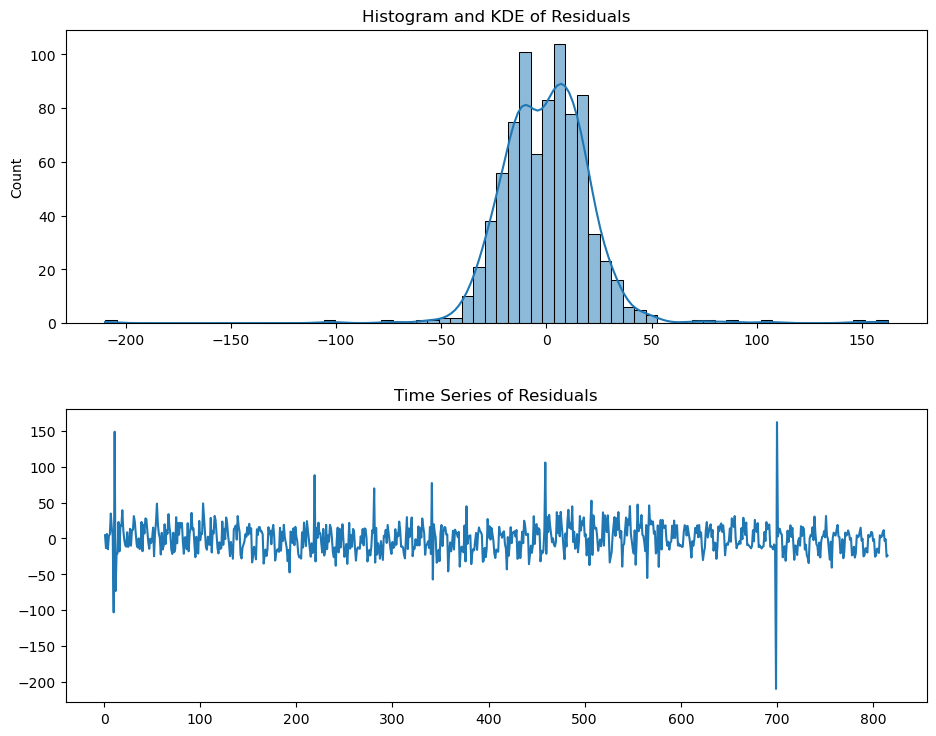

In [19]:
residuals = pd.Series(model_fit.resid, index=df.index)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
sns.histplot(residuals, ax=ax1, kde=True)
ax1.set_title('Histogram and KDE of Residuals')

residuals.plot(ax=ax2)
ax2.set_title('Time Series of Residuals')

plt.tight_layout(pad=3)
plt.show()

* The histogram shows an appromimately normal distribution. There are long tails at either end however the number of observations is small indicating probable outliers or an external influence.
<br>

* The time series plot shows the same minor seasonality seen earlier.
<br>
* It appears to be a logical model for the data however some further data preprocessing, a deep evaluation of the mild seasonality, and maybe the addition of another feature from another data set would be adventageous. Those items are outside the scope of this assignment however peak a interest and may be explored at a furter date.